# "The Battle of Neighborhoods" - Restaurant Problem

### Author: Shreya Biswas

## Contents:
1. [Introduction](#introduction)
     * a. [Background](#background)
     * b. [Business Understanding and Problem Statement](#business_understanding)
     
2. [Data](#data)
     * a. [Data Requirements](#data_requirements)
     * b. [Data Processing for Exploratory Analysis and Model Fitting](#data_processing)
     
3. [Methodology](#methodology)
     * a. [Exploring the Different Localities in Gurugram](#exploratory_analysis)
     * b. [Clustering the Different Localities in Gurugram](#clustering)
     
4. [Results](#results)

5. [Conclusion](#conclusion)

6. [Discussion and Future Scope](#discussion)

7. [References](#references)

## 1. Introduction <a class="anchor" id="introduction"></a>
This project has been completed as part of the **IBM Applied Data Science Capstone** course and applies the unsupervised machine learning algorithm of *K-Means clustering* to the problem of identifying a suitable location for opening a new restaurant in the city of Gurugram, India.

### 1a. Background <a class="anchor" id="background"></a>
The *National Capital Region (NCR)* of India comprises the prominent urban cities of *New Delhi* (also the capital city), **Gurugram** (formerly Gurgaon), and *Noida*, along with several other adjoining districts. Of these cities, Gurugram, owing to its large multicultural local population as well as a steady tourist footfall - both domestic and international (at least during the pre-Covid era), represents a metropolitan milieu that is particularly conducive to opening a new themed restaurant or café, especially from the perspective of a small to medium-sized enterprise, or even a large and established restaurant chain. 

### 1b. Business Understanding and Problem Statement <a class="anchor" id="business_understanding"></a>
Having discussed the eminence of the city of Gurugram, India as a lucrative location for opening a new themed eatery, the goal of this project will be to assist businesses interested in opening a new restaurant or café within Gurugram, in identifying appropriate neighborhoods (or localities) for their venture. Recommendations regarding localities will be based on several important factors such as popular types of eateries across the localities, customer traffic in each locality, and competition from pre-existing food joints in each locality. 

Hence, the two-part problem that this project will aim to solve can be defined – 

* **A. Which neighborhoods (or localities) of Gurugram are ideal for opening a new restaurant or café?**
* **B. If a new restaurant or café is opened in the neighborhood (or locality) of choice, which cuisine would have the greatest chance of success?**

## 2. Data <a class="anchor" id="data"></a>

### 2a. Data Requirements <a class="anchor" id="data_requirements"></a>
With some clarity regarding the questions to be answered via this project, it is evident that the data required would comprise a **listing of the major localities within the city of Gurugram**, along with their **geospatial location data (i.e., latitude and longitude coordinates)**. A reasonably comprehensive dataset for obtaining the aforementioned geospatial data is the Zomato API dataset available on Kaggle (<a href="https://www.kaggle.com/shrutimehta/zomato-restaurants-data?select=zomato.csv" target="_blank"> Link </a>).Thereafter, the geospatial location data of the localities can be utilized to explore the different neighborhoods, i.e., retrieve data regarding the eateries in geographical proximity to a particular neighborhood, analyze the most popular cuisines of eateries in different neighborhoods, etc., using **Foursquare API** (<a href="https://developer.foursquare.com/docs/places-api/" target="_blank"> Link </a>).

### 2b. Data Processing for Exploratory Analysis and Model Fitting <a class="anchor" id="data_processing"></a>

In [36]:
# import necessary libraries and modules
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim 
!pip install folium
import folium
import requests
import json
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

Create credentials to access the *zomato.csv* file uploaded to the IBM Cloud Object Storage

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
# define function for loading datasets from IBM cloud object storage into the project
from ibm_botocore.client import Config
import ibm_boto3
def download_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.download_file(Bucket=credentials['BUCKET'],Key=key,Filename=local_file_name)
    except Exception as e:
        print(Exception, e)
    else:
        print('File Downloaded')

In [4]:
# load the zomato.csv dataset uploaded to IBM cloud object storage for use within the project 
download_file_cos(credentials_2, 'zomato.csv', 'zomato.csv')

File Downloaded


In [5]:
# read in the zomato.csv dataset into a pandas dataframe
zomato_raw_data = pd.read_csv('zomato.csv', encoding = "ISO-8859-1")
zomato_raw_data.head()

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",1100,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,1200,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",4000,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",1500,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",1500,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


As we can see, the **zomato.csv** dataset comprises **21 columns**. For this project, the data in all 21 columns will not be required, but first let's see what the column names are, along with their data types.

In [6]:
# display column names with respective data types
zomato_raw_data.dtypes

Restaurant ID             int64
Restaurant Name          object
Country Code              int64
City                     object
Address                  object
Locality                 object
Locality Verbose         object
Longitude               float64
Latitude                float64
Cuisines                 object
Average Cost for two      int64
Currency                 object
Has Table booking        object
Has Online delivery      object
Is delivering now        object
Switch to order menu     object
Price range               int64
Aggregate rating        float64
Rating color             object
Rating text              object
Votes                     int64
dtype: object

With the column names handy, we can now trim the **zomato_raw_data** dataframe to contain only the data relevant to this project.

In [7]:
# trim the zomato raw data to contain data pertaining to the city of 'Gurgaon' (or Gurugram) only
city = ['Gurgaon']
zomato_gurgaon = zomato_raw_data[zomato_raw_data.City.str.contains('|'.join(city))]

In [8]:
# verify that the zomato_gurgaon dataframe contains data pertaining only to the relevant city of Gurgaon
zomato_gurgaon['City'].value_counts()

Gurgaon    1118
Name: City, dtype: int64

With the dataset trimmed to only the relevant city of *Gurgaon*, we can now further process it to contain only the columns pertaining to **geospatial data (latitude and longitude coordinates)** for the different localities in Gurgaon (or Gurugram).

In [9]:
# create new dataframe with only the relevant columns
relevant_columns = ['City', 'Locality', 'Latitude', 'Longitude']
zomato_geospatial = zomato_gurgaon[relevant_columns]
# clean the dataframe for clarity
zomato_geospatial_final = zomato_geospatial.drop_duplicates(subset='Locality', keep='first', inplace=False) # remove rows with duplicate localities
zomato_geospatial_final.index = np.arange(0, len(zomato_geospatial_final)) # set index of dataframe to start from 0
zomato_geospatial_final.head()

,City,Locality,Latitude,Longitude
0,Gurgaon,Sohna Road,28.424831,77.039310
1,Gurgaon,Ambience Mall,28.503077,77.097118
2,Gurgaon,Palam Vihar,28.511416,77.042009
3,Gurgaon,Ardee City,28.440709,77.087851
4,Gurgaon,Sector 15,28.458088,77.034715


Now that the **zomato geospatial data** is ready, any *missing values* or *outliers* in the dataframe can be handled.

In [10]:
# check whether the zomato_geospatial_final dataframe contains missing values
print(f"The zomato_geospatial dataframe has {zomato_geospatial_final.shape[0]} rows, {zomato_geospatial_final.shape[1]} columns")
zomato_geospatial_final.info()

The zomato_geospatial dataframe has 45 rows, 4 columns
<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 0 to 44
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   City       45 non-null     object 
 1   Locality   45 non-null     object 
 2   Latitude   45 non-null     float64
 3   Longitude  45 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.8+ KB


The output above indicates that the **zomato_geospatial_final** dataframe contains 45 rows of data, with none of the rows containing any *null* values. 

In [11]:
# handle outliers in the "Latitude" and "Longitude" columns
zomato_geospatial_final.drop(zomato_geospatial_final[zomato_geospatial_final['Latitude'] < 28].index, inplace = True)
zomato_geospatial_final.drop(zomato_geospatial_final[zomato_geospatial_final['Latitude'] > 29].index, inplace = True)
zomato_geospatial_final.drop(zomato_geospatial_final[zomato_geospatial_final['Longitude'] < 77].index, inplace = True)
zomato_geospatial_final.drop(zomato_geospatial_final[zomato_geospatial_final['Longitude'] > 78].index, inplace = True)
print(f"The zomato_geospatial_final dataframe has {zomato_geospatial_final.shape[0]} rows, {zomato_geospatial_final.shape[1]} columns")

The zomato_geospatial_final dataframe has 45 rows, 4 columns


From the output above, we can see that after dropping the rows containing missing values and outliers (erroneous entries such as "0" for *Latitute* and/or *Longitude* values) from the dataframe, the cleaned **zomato_geospatial_final** dataframe consists of **45** rows, i.e., no rows contained any missing or outlier values for *Latitude* and *Longitude*. Thus, the **zomato geospatial data** is now ready for exploratory data analysis and model fitting/evaluation.

## 3. Methodology <a class="anchor" id="methodology"></a>

### 3a. Exploring the Different Localities in Gurugram <a class="anchor" id="exploratory_analysis"></a>

In [12]:
# use geopy to determine the location coordinates of the address
address = 'Gurugram, India'
geolocator = Nominatim(user_agent='NCR_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Gurugram, India are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Gurugram, India are 28.4646148, 77.0299194.


In [13]:
# visualize the localities in Gurgaon (or Gurugram) on a map using Folium
Gurgaon_map = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, locality, city in zip(zomato_geospatial_final['Latitude'], zomato_geospatial_final['Longitude'], zomato_geospatial_final['Locality'], zomato_geospatial_final['City']):
  label = '{}, {}'.format(locality, city)
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker(
      [lat, lng],
      radius=5,
      popup=label,
      color='blue',
      fill=True,
      fill_color='#3186cc',
      fill_opacity=0.7).add_to(Gurgaon_map)
# display map
Gurgaon_map

As visualized in the map above, all 45 unique localities in the city of Gurugram (as per the the **zomato_geospatial_final** dataframe) have been plotted. Next, we can retrieve the *nearby venues* for each locality in Gurugram using **Foursquare API**. The limit for the maximum number of venues returned will be set to *100* for each locality, and the radius to *500* meters. 

In [14]:
# The code was removed by Watson Studio for sharing.

My credentials:
CLIENT_ID: 05IE01XPM0CQDWBKXBYFDUSQF3MLTIJAIAENDF3SR1PKRQG4
CLIENT_SECRET:VV0PVCXE3DKYBIZIHE1GVUMJHFFRKDTBLPFUP52VZDO4F1WK


In [15]:
# set radius and limit
radius = 500
limit = 100

# initialize an empty list to be filled with venues
venues = []

for lat, lng, locality in zip(zomato_geospatial_final['Latitude'], zomato_geospatial_final['Longitude'], zomato_geospatial_final['Locality']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius, 
        limit)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            locality,
            lat, 
            lng, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [16]:
# cast the list of venues to a dataframe
venues_data = pd.DataFrame(venues)
# name the columns
venues_data.columns = ['Locality', 'Latitude', 'Longitude', 'Venue Name', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
venues_data.head()

,Locality,Latitude,Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Sohna Road,28.424831,77.03931,Brewer Street,28.424499,77.039134,Brewery
1,Sohna Road,28.424831,77.03931,Decathlon Gurgaon,28.427433,77.036258,Sporting Goods Shop
2,Sohna Road,28.424831,77.03931,KFC,28.424789,77.038722,Fast Food Restaurant
3,Sohna Road,28.424831,77.03931,Sagar Ratna,28.421042,77.038509,Indian Restaurant
4,Sohna Road,28.424831,77.03931,Grand cinemas,28.423626,77.039422,Movie Theater


It is evident that the **venues_data** dataframe contains several venue categories that are irrelevant to this project, e.g. *Sporting Goods Shop*, *Movie Theater*, etc. Since this project is concerned with eateries only, different types of eateries, e.g. *Brewery*, *Fast Food Restaurant*, *Indian Restaurant* will be filtered out from the **venues_data** dataframe to create a new dataframe pertaining to data for eateries only.

In [17]:
# display all unique categories of venues
print('The total number of unique venue categories is', len(venues_data['Venue Category'].unique()))
venues_list = venues_data['Venue Category'].unique()
venues_list

The total number of unique venue categories is 108


array(['Brewery', 'Sporting Goods Shop', 'Fast Food Restaurant',
       'Indian Restaurant', 'Movie Theater', 'Department Store',
       'BBQ Joint', 'Shopping Mall', 'Bowling Alley',
       'American Restaurant', 'Bar', 'Hotel', 'Multiplex', 'Donut Shop',
       'Café', 'Coffee Shop', 'Clothing Store', 'Italian Restaurant',
       'Bookstore', 'Restaurant', 'Mediterranean Restaurant',
       'Skating Rink', 'Asian Restaurant', 'Gym', 'Arcade', 'Food Court',
       'Diner', 'Pizza Place', 'Sandwich Place', 'Beer Garden',
       'Thai Restaurant', 'Chinese Restaurant', 'Bakery',
       'Scenic Lookout', 'Mexican Restaurant', 'Falafel Restaurant',
       'Gourmet Shop', 'Ice Cream Shop', 'Nightclub', 'Hookah Bar',
       'Steakhouse', 'Resort', 'Japanese Restaurant', 'Go Kart Track',
       'Hotel Bar', 'Dessert Shop', 'Market', 'Bagel Shop', 'Lounge',
       'Tapas Restaurant', 'Burger Joint', 'Tea Room',
       'Electronics Store', 'Brazilian Restaurant', 'Park',
       'Korean Restaur

In [18]:
# filter out eateries from the 'Venue Category' column of the 'venues_data' dataframe
eatery_filter = ['Brewery', 'Restaurant', 'Joint', 'Bar', 'Donut', 'Café', 'Coffee', 'Food', 'Diner', 'Pizza', 'Sandwich', 'Beer', 'Bakery', 'Gourmet', \
                 'Ice cream', 'Steakhouse', 'Bagel', 'Tea', 'Burger', 'Deli', 'Bistro', 'Gastropub', 'Joint', 'Dhaba', 'Buffet', 'Dessert', 'Place', \
                 'Yogurt', 'Juice', 'Cafe', 'Sweet', 'Cafeteria' ]
eatery_list = []
for item in eatery_filter:
    substring = [string for string in venues_list if item in string]
    eatery_list.extend(substring)
eatery_list

['Brewery',
 'Fast Food Restaurant',
 'Indian Restaurant',
 'American Restaurant',
 'Italian Restaurant',
 'Restaurant',
 'Mediterranean Restaurant',
 'Asian Restaurant',
 'Thai Restaurant',
 'Chinese Restaurant',
 'Mexican Restaurant',
 'Falafel Restaurant',
 'Japanese Restaurant',
 'Tapas Restaurant',
 'Brazilian Restaurant',
 'Korean Restaurant',
 'Burmese Restaurant',
 'Middle Eastern Restaurant',
 'Portuguese Restaurant',
 'New American Restaurant',
 'Cantonese Restaurant',
 'Vegetarian / Vegan Restaurant',
 'Moroccan Restaurant',
 'Caribbean Restaurant',
 'Kerala Restaurant',
 'Seafood Restaurant',
 'French Restaurant',
 'BBQ Joint',
 'Burger Joint',
 'Fried Chicken Joint',
 'Bar',
 'Hookah Bar',
 'Hotel Bar',
 'Wine Bar',
 'Whisky Bar',
 'Donut Shop',
 'Café',
 'Coffee Shop',
 'Fast Food Restaurant',
 'Food Court',
 'Food & Drink Shop',
 'Food Truck',
 'Food Stand',
 'Food',
 'Diner',
 'Pizza Place',
 'Sandwich Place',
 'Beer Garden',
 'Bakery',
 'Gourmet Shop',
 'Steakhouse',
 

In [19]:
# create a new dataframe using the filtered out eateries from the 'Venue Category' column of the 'venues_data' dataframe
Gurgaon_eateries = venues_data[venues_data['Venue Category'].str.contains('|'.join(eatery_list))]
Gurgaon_eateries.head()

,Locality,Latitude,Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Sohna Road,28.424831,77.03931,Brewer Street,28.424499,77.039134,Brewery
2,Sohna Road,28.424831,77.03931,KFC,28.424789,77.038722,Fast Food Restaurant
3,Sohna Road,28.424831,77.03931,Sagar Ratna,28.421042,77.038509,Indian Restaurant
5,Sohna Road,28.424831,77.03931,Torgauer Brewpub,28.423641,77.039426,Brewery
7,Sohna Road,28.424831,77.03931,Barbeque Nation,28.421888,77.040544,BBQ Joint


In [20]:
Gurgaon_eateries['Venue Category'].unique()

array(['Brewery', 'Fast Food Restaurant', 'Indian Restaurant',
       'BBQ Joint', 'American Restaurant', 'Bar', 'Donut Shop', 'Café',
       'Coffee Shop', 'Italian Restaurant', 'Restaurant',
       'Mediterranean Restaurant', 'Asian Restaurant', 'Food Court',
       'Diner', 'Pizza Place', 'Sandwich Place', 'Beer Garden',
       'Thai Restaurant', 'Chinese Restaurant', 'Bakery',
       'Mexican Restaurant', 'Falafel Restaurant', 'Gourmet Shop',
       'Hookah Bar', 'Steakhouse', 'Japanese Restaurant', 'Hotel Bar',
       'Dessert Shop', 'Bagel Shop', 'Tapas Restaurant', 'Burger Joint',
       'Tea Room', 'Brazilian Restaurant', 'Korean Restaurant',
       'Deli / Bodega', 'Bistro', 'Burmese Restaurant',
       'Middle Eastern Restaurant', 'Gastropub', 'Portuguese Restaurant',
       'Wine Bar', 'New American Restaurant', 'Cantonese Restaurant',
       'Vegetarian / Vegan Restaurant', 'Whisky Bar', 'Food & Drink Shop',
       'Moroccan Restaurant', 'Fried Chicken Joint',
       'Carib

By calling the *.unique()* function on the 'Venue Category' column of the **Gurgaon_eateries** dataframe above, it is clear that only those rows of data have been filtered out from the **venues_data** dataframe wherein the 'Venue Category' column contained a type of eatery (e.g. 'Brewery', 'Fast Food Restaurant', 'Indian Restaurant', etc). We can now perform some further exploratory data analysis.

In [21]:
print(f"Major types of eateries in Gurugram: {len(Gurgaon_eateries['Venue Category'].unique())}")

Major types of eateries in Gurugram: 57


In [22]:
# create a dataframe with the different types of eateries and their respective counts
eatery_counts = Gurgaon_eateries['Venue Category'].value_counts().to_frame(name='counts')
eatery_counts = eatery_counts.reset_index()
eatery_counts.rename(index=str, columns={"index": "venue_category"}, inplace=True)

In [23]:
# display the top 10 types of eateries in Gurgaon (or Gurugram)
eatery_counts.head(10)

,venue_category,counts
0,Indian Restaurant,53
1,Café,36
2,Coffee Shop,24
3,Pizza Place,23
4,Fast Food Restaurant,19
5,Chinese Restaurant,17
6,Brewery,15
7,Restaurant,12
8,Bar,11
9,Asian Restaurant,10


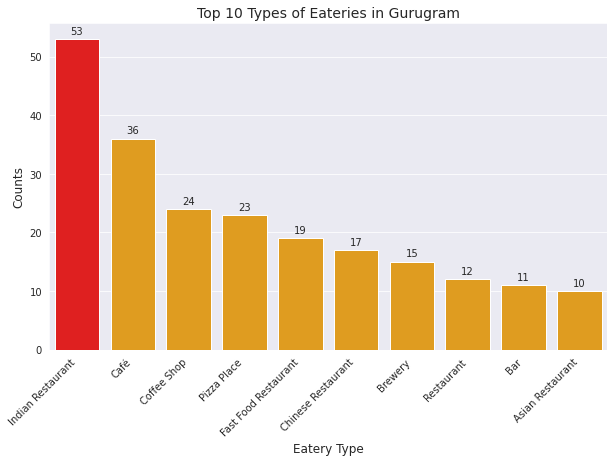

In [24]:
# generate a bar plot to visualize the top 10 types of eateries in Gurgaon (or Gurugram)
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10,6))
colors = ['orange' if (x < eatery_counts['counts'].max()) else 'red' for x in eatery_counts['counts']]
fig = sns.barplot(x ='venue_category', y ='counts', data = eatery_counts[0:10], palette = colors)
plt.title('Top 10 Types of Eateries in Gurugram', fontsize=14)
plt.xlabel('Eatery Type', fontsize=12)
plt.ylabel ("Counts", fontsize=12)
plt.xticks(rotation=45,  horizontalalignment='right')

for bar in fig.patches:
    # determine the coordinates for annotation of the bars with text labels
    fig.annotate(format(bar.get_height(), '.0f'), 
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', 
                 va='center',
                 size=10, xytext=(0, 8),
                 textcoords='offset points')

plt.savefig('Top 10 Types of Eateries in Gurugram.png')
plt.show()

From the bar plot above, it is evident that the most popular type of eatery in Gurugram is **Indian Restaurant**. Hence, opening a new Indian restaurant would be a good idea in general, ensuring a regular inflow of customers. Now, we would need to identify locations within Gurugram with a steady customer footfall (or medium to high density of pre-existing eateries), wherein no Indian restaurants exist (minimizing competition from the same type of eatery) for opening the new Indian restaurant. This can be done via further exploratory data analysis and *K-means clustering*. 

In [25]:
# check the density of pre-existing eateries in the various localities in Gurgaon (or Gurugram)
Gurgaon_eateries.groupby(['Locality'])['Venue Category'].count().sort_values(ascending=False)

Locality
DLF Cyber City                     53
Sector 29                          31
DLF Phase 4                        28
Ambience Mall                      26
MG Road                            21
Sector 54                          17
DLF Phase 5                        15
Golf Course Road                   14
DLF Phase 2                        13
Sushant Lok                        11
Woods Resort                       11
DLF Phase 1                         9
Omaxe Gurgaon Mall                  7
Sector 21                           7
Udyog Vihar                         6
DLF Phase 3                         6
Hyatt Place Gurgaon                 5
Sector 23                           5
Sohna Road                          5
Sector 57                           5
Sector 30                           5
Sector 22                           5
Ardee City                          4
Country Inn & Suites by Carlson     4
Sikandarpur                         4
Sector 56                           3
Pal

From the **Gurgaon_eateries** dataframe grouped by 'Locality' and 'Venue Category' above, we can see that *DLF Cyber City* and *Sector 29* are some of the most popular localities within Gurugram in terms of restaurant density, thus ensuring steady customer traffic. Other localities of Gurugram with a medium density of restaurants (and hence, still reasonably good customer traffic) are *DLF Phase 4*, *Ambience Mall*, and *MG Road*. 
However, the ideal location for opening a new *Indian restaurant* would be a **locality with a medium to high restaurant density but no pre-existing Indian restaurant**. Such a location can be identified by creating a grouped dataframe from the **Gurgaon_eateries** dataframe via one-hot encoding and analyzing each locality within Gurugram via clustering and selecting localities within clusters wherein no Indian restaurants (or few) exist. 

In [26]:
# one hot encoding
Gurgaon_onehot = pd.get_dummies(Gurgaon_eateries[['Venue Category']], prefix="", prefix_sep="")

# add 'Locality' column back to the dataframe
Gurgaon_onehot['Locality'] = Gurgaon_eateries['Locality'] 

# move 'Locality' column to the first column
fixed_columns = [Gurgaon_onehot.columns[-1]] + list(Gurgaon_onehot.columns[:-1])
Gurgaon_onehot = Gurgaon_onehot[fixed_columns]

# set index of dataframe to start from 0
Gurgaon_onehot.index = np.arange(0, len(Gurgaon_onehot)) 

Gurgaon_onehot.head()

,Locality,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Garden,Bistro,Brazilian Restaurant,Brewery,Burger Joint,Burmese Restaurant,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Deli / Bodega,Dessert Shop,Diner,Donut Shop,Falafel Restaurant,Fast Food Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Gourmet Shop,Hookah Bar,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kerala Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Pizza Place,Portuguese Restaurant,Restaurant,Sandwich Place,Seafood Restaurant,Snack Place,Steakhouse,Tapas Restaurant,Tea Room,Thai Restaurant,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar
0,Sohna Road,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Sohna Road,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Sohna Road,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Sohna Road,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Sohna Road,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
# group the Gurgaon_onehot dataframe by locality and take the mean of the frequency of occurrence of each type of eatery
Gurgaon_eateries_grouped = Gurgaon_onehot.groupby('Locality').mean().reset_index()
Gurgaon_eateries_grouped

,Locality,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Garden,Bistro,Brazilian Restaurant,Brewery,Burger Joint,Burmese Restaurant,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Deli / Bodega,Dessert Shop,Diner,Donut Shop,Falafel Restaurant,Fast Food Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Gourmet Shop,Hookah Bar,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kerala Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Pizza Place,Portuguese Restaurant,Restaurant,Sandwich Place,Seafood Restaurant,Snack Place,Steakhouse,Tapas Restaurant,Tea Room,Thai Restaurant,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar
0,Ambience Mall,0.076923,0.076923,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115385,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.038462,0.038462,0.000000,0.115385,0.000000,0.000000,0.038462,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230769,0.076923,0.000000,0.0,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Ardee City,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000
2,Country Inn & Suites by Carlson,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,DLF Cyber City,0.018868,0.056604,0.018868,0.000000,0.000000,0.056604,0.000000,0.018868,0.000000,0.018868,0.000000,0.018868,0.075472,0.018868,0.000000,0.000000,0.113208,0.000000,0.000000,0.000000,0.037736,0.018868,0.056604,0.000000,0.000000,0.037736,0.000000,0.0,0.000000,0.000000,0.018868,0.000000,0.000000,0.000000,0.150943,0.018868,0.000000,0.0,0.000000,0.037736,0.018868,0.018868,0.000000,0.018868,0.056604,0.018868,0.000000,0.018868,0.000000,0.000000,0.000000,0.000000,0.018868,0.000000,0.018868,0.000000,0.018868
4,DLF Phase 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.222222,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.000000,0.000000,0.111111,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,DLF Phase 2,0.076923,0.000000,0.000000,0.000000,0.076923,0.076923,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.076923,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230769,0.000000,0.000000,0.0,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,DLF Phase 3,

In [28]:
# display each locality along with its top 10 common types of eateries
num_top_venues = 10

for locality in Gurgaon_eateries_grouped['Locality']:
    print("********** "+locality+" **********")
    temp = Gurgaon_eateries_grouped[Gurgaon_eateries_grouped['Locality'] == locality].T.reset_index()
    temp.columns = ['Eatery type','Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

********** Ambience Mall **********
                Eatery type  Frequency
0         Indian Restaurant       0.23
1                      Café       0.12
2      Fast Food Restaurant       0.12
3        Italian Restaurant       0.08
4          Asian Restaurant       0.08
5       American Restaurant       0.08
6                       Bar       0.08
7                     Diner       0.04
8                Food Court       0.04
9  Mediterranean Restaurant       0.04


********** Ardee City **********
               Eatery type  Frequency
0          Thai Restaurant       0.25
1        Indian Restaurant       0.25
2              Beer Garden       0.25
3       Chinese Restaurant       0.25
4      American Restaurant       0.00
5  New American Restaurant       0.00
6               Hookah Bar       0.00
7                Hotel Bar       0.00
8       Italian Restaurant       0.00
9      Japanese Restaurant       0.00


********** Country Inn & Suites by Carlson **********
               Eatery type

In [29]:
# define function to sort the eatery types in descending order
def most_common_eateries(row, num_top_venues):
    row_eatery_types = row.iloc[1:]
    row_eatery_types_sorted = row_eatery_types.sort_values(ascending=False)
    
    return row_eatery_types_sorted.index.values[0:num_top_venues]

In [30]:
# create a new dataframe containing the top 10 eatery types for each locality
number_labels = ['st', 'nd', 'rd']

columns = ['Locality']
for label in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Eatery'.format(label+1, number_labels[label]))
    except:
        columns.append('{}th Most Common Eatery'.format(label+1))

Gurgaon_eateries_sorted = pd.DataFrame(columns=columns)
Gurgaon_eateries_sorted['Locality'] = Gurgaon_eateries_grouped['Locality']

for label in np.arange(Gurgaon_eateries_grouped.shape[0]):
    Gurgaon_eateries_sorted.iloc[label, 1:] = most_common_eateries(Gurgaon_eateries_grouped.iloc[label, :], num_top_venues)

Gurgaon_eateries_sorted.head()

,Locality,1st Most Common Eatery,2nd Most Common Eatery,3rd Most Common Eatery,4th Most Common Eatery,5th Most Common Eatery,6th Most Common Eatery,7th Most Common Eatery,8th Most Common Eatery,9th Most Common Eatery,10th Most Common Eatery
0,Ambience Mall,Indian Restaurant,Café,Fast Food Restaurant,Italian Restaurant,Asian Restaurant,American Restaurant,Bar,Diner,Food Court,Mediterranean Restaurant
1,Ardee City,Thai Restaurant,Indian Restaurant,Beer Garden,Chinese Restaurant,American Restaurant,New American Restaurant,Hookah Bar,Hotel Bar,Italian Restaurant,Japanese Restaurant
2,Country Inn & Suites by Carlson,Japanese Restaurant,Indian Restaurant,Café,American Restaurant,New American Restaurant,Gourmet Shop,Hookah Bar,Hotel Bar,Italian Restaurant,Kerala Restaurant
3,DLF Cyber City,Indian Restaurant,Coffee Shop,Café,Fast Food Restaurant,Asian Restaurant,Bar,Pizza Place,Donut Shop,Food Court,Mediterranean Restaurant
4,DLF Phase 1,Fast Food Restaurant,Coffee Shop,Indian Restaurant,Food Court,Restaurant,Café,Pizza Place,Hotel Bar,Italian Restaurant,Japanese Restaurant


### 3b. Clustering the Different Localities in Gurugram <a class="anchor" id="clustering"></a>

#### *K-Means Clustering*
K-means clustering is an unsupervised machine learning algorithm used for partitioning *n* data points into *k* clusters, as per which each data point is assigned to the cluster with the nearest mean (cluster center or cluster centroid), serving as representative of the cluster. The optimized algorithm minimizes the intra-cluster *sum-of-squared-errors*. The squared error for each data point is the square of the distance (Euclidean or Manhattan, for example) of the data point from its predicted cluster center/centroid (<a href="https://en.wikipedia.org/wiki/K-means_clustering" target="_blank"> Source </a>).

For this project, *K-means clustering* will be used to cluster the localities in Gurugram according to the frequency of occurence of different types of eateries within the city. 

#### *Selecting the Optimal Value of K for K-Means Clustering*

#### Elbow Method

The Elbow method works by calculating the *Inertia*, or the Within-Cluster-Sum of Squared Errors (WSS) for different values of k, and selecting the value of k for which WSS first starts to stabilize. In the plot of *K vs Inertia*, this will be made evident by an "elbow" in the curve (<a href="https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb" target="_blank"> Source </a>). 

#### Silhouette Method
The Silhouette Score measures how similar a data point is to its own cluster (cohesion) compared to other clusters (separation). The range of the Silhouette Score is between +1 and -1. A high value is desirable and indicates that the data point is assigned to the correct cluster. If many data points have a negative Silhouette Score, it may indicate that too many or too few clusters have been created. Generally, Euclidean distance is used as the distance metric. The Silhouette Score reaches its global maximum at the optimal k, appearing as a peak in the *K vs Silhouette Score* plot (<a href="https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb" target="_blank"> Source </a>).

Both *Inertia* and *Silhouette Score* can be easily calculated using the *metrics* module of the *sklearn* library.

For this project, the *Elbow* method will be used for selecting the optimal value of k for model building, whereas the *Silhouette* method will be used for model evaluation and refinement. 

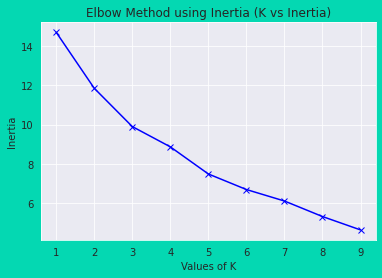

In [31]:
# create dataframe for clustering
Gurgaon_clustering = Gurgaon_eateries_grouped.drop(['Locality'], 1)

# initialize a list to hold the inertia values for each 'k'
inertia_values = []

# populate the list
for k in range(1,10):
  k_means_model = KMeans(init='k-means++', n_clusters=k, random_state=38).fit(Gurgaon_clustering)
  inertia_values.append(k_means_model.inertia_)
    
# create plot illustrating the performance (measured by inertia values) against the iterated values of 'k'
K = range(1,10)
fig = plt.figure()
fig.patch.set_facecolor('xkcd:aquamarine')
plt.plot(K, inertia_values, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('Elbow Method using Inertia (K vs Inertia)') 
plt.show()

From the plot of *k vs inertia* above, we can see that there is no clear elbow. Hence, for the k-means clustering model built in this project, it appears that the **elbow method** is not a good metric for selecting the optimal value of k (or number of clusters). Hence, we can use another metric for selecting the optimal value of k, namely, the **Silhouette Score**. 

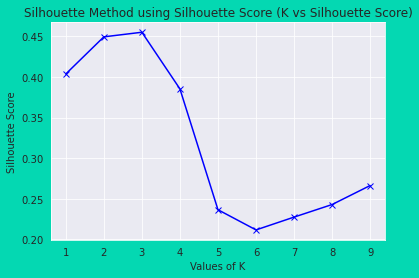

In [32]:
# initialize a list to hold the silhouette score values for each 'k'
silhouette_scores = []
kmax = 10

# dissimilarity cannot defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  k_means_model = KMeans(init='k-means++', n_clusters=k, random_state=38).fit(Gurgaon_clustering)
  labels = k_means_model.labels_
  silhouette_scores.append(silhouette_score(Gurgaon_clustering, labels, metric = 'euclidean'))

# create plot illustrating the performance (measured by inertia values) against the iterated values of 'k'
K = range(1,10)
fig = plt.figure()
fig.patch.set_facecolor('xkcd:aquamarine')
plt.plot(K, silhouette_scores, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette Score') 
plt.title('Silhouette Method using Silhouette Score (K vs Silhouette Score)') 
plt.show()

From the plot of *k vs silhouette score* above, we can see that it is a much better metric for selecting the optimal value of k for the k-means clustering model built in this project, as there is a clear peak in the curve at **k = 3**. Therefore, it appears that the localities in Gurgaon (or Gurugram) can potentially be optimally partitioned into *3 clusters*. 

Now, we can use the **k-means clustering** algorithm to cluster the localities in Gurgaon (or Gurugram) into *3 clusters*. 

In [33]:
# initialize the number of clusters
k = 3

# build the k-means clustering model
k_means_model = KMeans(init='k-means++', n_clusters=k, random_state=38).fit(Gurgaon_clustering)

# check cluster labels generated for each row in the dataframe
k_means_model.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
      dtype=int32)

## 4. Results <a class="anchor" id="results"></a>

Having clustered the different localities in Gurgaon (or Gurugram) using the *K-Means clustering* algorithm and generated the cluster labels, we will npw create a final dataframe displaying the results of the clustering, by adding the cluster labels for each locality in Gurgaon (or Gurugram) to the **Gurgaon_eateries_sorted** dataframe and merging with the **zomato_geospatial_final** dataframe. 

In [34]:
# add cluster labels to the Gurgaon_eateries_sorted dataframe
Gurgaon_eateries_sorted.insert(0, 'Cluster Labels', k_means_model.labels_)

Gurgaon_clusters_merged = zomato_geospatial_final

# merge the 'Gurgaon_clusters_merged' dataframe and 'Gurgaon_eateries_sorted' dataframe
Gurgaon_clusters_merged = Gurgaon_clusters_merged.join(Gurgaon_eateries_sorted.set_index('Locality'), on='Locality')

# drop rows with NaN values
Gurgaon_clusters_merged = Gurgaon_clusters_merged.dropna()

# convert the values in the 'Cluster Labels' column of the Gurgaon_clusters_merged dataframe into integers
Gurgaon_clusters_merged['Cluster Labels'] = Gurgaon_clusters_merged['Cluster Labels'].astype('int')

Gurgaon_clusters_merged.head()

,City,Locality,Latitude,Longitude,Cluster Labels,1st Most Common Eatery,2nd Most Common Eatery,3rd Most Common Eatery,4th Most Common Eatery,5th Most Common Eatery,6th Most Common Eatery,7th Most Common Eatery,8th Most Common Eatery,9th Most Common Eatery,10th Most Common Eatery
0,Gurgaon,Sohna Road,28.424831,77.039310,0,Brewery,BBQ Joint,Indian Restaurant,Fast Food Restaurant,American Restaurant,New American Restaurant,Hookah Bar,Hotel Bar,Italian Restaurant,Japanese Restaurant
1,Gurgaon,Ambience Mall,28.503077,77.097118,0,Indian Restaurant,Café,Fast Food Restaurant,Italian Restaurant,Asian Restaurant,American Restaurant,Bar,Diner,Food Court,Mediterranean Restaurant
2,Gurgaon,Palam Vihar,28.511416,77.042009,0,Pizza Place,Sandwich Place,Café,Moroccan Restaurant,Gourmet Shop,Hookah Bar,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Restaurant
3,Gurgaon,Ardee City,28.440709,77.087851,0,Thai Restaurant,Indian Restaurant,Beer Garden,Chinese Restaurant,American Restaurant,New American Restaurant,Hookah Bar,Hotel Bar,Italian Restaurant,Japanese Restaurant
4,Gurgaon,Sector 15,28.458088,77.034715,2,Asian Restaurant,Moroccan Restaurant,Gastropub,Gourmet Shop,Hookah Bar,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kerala Restaurant


Thereafter, the clustered localities in Gurgaon (or Gurugram) can be visualized on a map using Folium.

In [37]:
# initialize map
Gurgaon_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.tab10(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, locality, cluster in zip(Gurgaon_clusters_merged['Latitude'],
                                  Gurgaon_clusters_merged['Longitude'],
                                  Gurgaon_clusters_merged['Locality'], 
                                  Gurgaon_clusters_merged['Cluster Labels']):
    label = folium.Popup(str(locality) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],
                        radius=5,
                        popup=label,
                        color=rainbow[cluster-1],
                        fill=True,
                        fill_color=rainbow[cluster-1],
                        fill_opacity=0.7).add_to(Gurgaon_clusters_map)
       
# display map
Gurgaon_clusters_map

In [38]:
# display the distribution of the different localities of Gurgaon (or Gurugram) by cluster labels, i.e., 0, 1, or 2
Gurgaon_clusters_merged.groupby(['Cluster Labels'])['Locality'].value_counts()

Cluster Labels  Locality                       
0               Ambience Mall                      1
                Ardee City                         1
                Country Inn & Suites by Carlson    1
                DLF Cyber City                     1
                DLF Phase 1                        1
                DLF Phase 2                        1
                DLF Phase 3                        1
                DLF Phase 4                        1
                DLF Phase 5                        1
                Golf Course Road                   1
                Hyatt Place Gurgaon                1
                MG Road                            1
                Old Railway Road                   1
                Omaxe Gurgaon Mall                 1
                Palam Vihar                        1
                Sadar Bazar                        1
                Sector 12                          1
                Sector 14                          

From the Folium visualization of the clusters and the **Gurgaon_clusters_merged** dataframe grouped by 'Cluster Labels' and 'Locality' above, it is evident that *K-Means clustering* has partitioned the localities in Gurgaon (or Gurugram) into **3 clusters** (labelled as **0**, **1**, and **2**).
* **Cluster 0** is indicated via *cyan* markers and has been assigned the most number of localities (38). 
* **Cluster 1** is indicated via *blue* markers and has been assigned 3 localities (Sector 43, Sector 44, and South City 2).
* **Cluster 2** is indicated via *brown* markers and has been assigned 2 localities (Sector 15 and Sector 53).

## 5. Conclusion <a class="anchor" id="conclusion"></a>

Analyzing the partioning of the different localities in Gurugram into the three clusters, i.e., 0, 1, and 2, with reference to the density of pre-existing eateries in the various localities within the city (indicated by the **Gurgaon_eateries** dataframe grouped by 'Locality', and then 'Venue Category') as well as the top 10 common types of eateries in each locality of the city (indicated by the **Gurgaon_eateries_grouped** dataframe grouped by 'Locality'), it can be concluded that:
* *Cluster 1* and *Cluster 2* are assigned localities with the *least density of pre-existing eateries (indicative of low customer footfall)*. All these localities are listed as having only one restaurant within each of them. Hence, **the localities of Sector 43, Sector 44, South City 2, Sector 15, and Sector 53 in Gurugram will not be ideal locations for opening a new restaurant of any kind, if a steady customer footfall is desired.**
* Within *Cluster 0*, the localities of DLF Cyber City, Sector 29, DLF Phases 1-5, Ambience Mall, MG Road, Sector 54, and Golf Course Road are all *densely populated with pre-existing eateries and can ensure regular customer traffic*. However, all **these localities already have at least one pre-existing Indian restaurant within them. Hence, opening a new Indian restaurant in these localities will not be a good idea, keeping in mind competition from the same category of eatery**.
* Within *Cluster 0*, localities like *Woods Resort* (11 pre-existing eateries) and *Sector 21* (7 pre-existing eateries) have a medium density of established eateries which can be a reasonable measure of customer success. Further, these two localities do not have any Indian restaurant within them. 

**Thus, it can be concluded that the localities of *Woods Resort* and *Sector 21* in Gurugram are potentially good choices for opening a new Indian restaurant, taking into account both customer traffic and competition from the same type of eatery.**





## 6. Discussion and Future Scope <a class="anchor" id="discussion"></a>

As discussed, Gurgaon (officially *Gurugram*) is one of the major satellite cities of the *National Capital Region* of India, serving as a flourishing location for opening a new themed restaurant or café. Hence, the goal of this project was two-fold: 
* A. To analyze the various eateries in proximity to the localities within Gurugram in order to identify the most popular type of eatery across the localities.
* B. To identify appropriate localities within Gurugram for opening a new themed eatery, based on the most popular type of eatery aross the city, customer footfall, and competition from pre-existing eateries.

Objective A was fulfilled via exploratory data analysis, whereas the unsupervised machine learning technique of *K-Means clustering* was used to address objective B. 
It was concluded that *Indian Restaurant* is the most common type of eatery across Gurugram, and the localities of *Woods Resort* and *Sector 21* in Gurugram would be ideal for opening a new Indian restaurant, considering customer traffic and competition from other Indian restaurants.

Although geospatial data pertaining to the different localities of Gurugram was used for this project, future iterations of the same can take into account other types of data, e.g. average per capita income of each of the localities, property rates, demographics, etc.

## 7. References: <a class="anchor" id="references"></a>

1. *Course Materials for IBM Data Science Professional Certificate* (<a href="https://www.coursera.org/professional-certificates/ibm-data-science" target="_blank"> Source </a>).
2. *Working With IBM Cloud Object Storage In Python* (<a href="https://medium.com/@snehalgawas/working-with-ibm-cloud-object-storage-in-python-fe0ba8667d5f" target="_blank"> Source </a>).
3. *Kaggle: Zomato Restaurants Data* (<a href="https://www.kaggle.com/shrutimehta/zomato-restaurants-data?select=zomato.csv" target="_blank"> Source </a>).
4. *Foursquare API* (<a href="https://developer.foursquare.com/docs/places-api/" target="_blank"> Source </a>).
5. *How to Determine the Optimal K for K-Means?* (<a href="https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb" target="_blank"> Source </a>).
6. *K-Means Clustering algorithm*  (<a href="https://en.wikipedia.org/wiki/Gurgaon" target="_blank"> Source </a>).

*************************************************************************************************************************************************************